In [5]:
import numpy as np
from scipy.stats import t as student_t, multivariate_t, multivariate_normal
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize



In [2]:
def get_m_v(Y, C_pre, Psi_pre_inv, X1, X2, tau, sample = 'sample'):

    n = Y.shape[0]
    


    gamma = np.zeros(n) # point estimate of gamma

    if X1 is not None:
        r1 = X1.shape[1]
        A = C_pre[:,:r1]
        B = C_pre[:,r1:]
    else:
        B = C_pre


    v = np.abs(1+(tau[:,np.newaxis]*X2*np.dot(X2, np.dot(B.T, Psi_pre_inv).dot(B))).sum(1)) ** (-1)

    if X1 is not None:
        errors = Y - np.dot(X1,A.T)
    else:
        errors = Y.copy()

    m =  v*(errors*np.dot(tau[:,np.newaxis]*X2, B.T).dot(Psi_pre_inv)).sum(1)

    if sample == 'sample':
        gamma = np.random.normal(loc = m, scale = v**0.5)
    else:
        gamma = m


    return m, v, gamma


def get_tau(Y, X1,X2, gamma, C_pre, Psi_est_inv, nu, sample = 'sample'):

    n = Y.shape[0]
    d = Y.shape[1]
    

    if X1 is not None:
        r1 = X1.shape[1]
        A = C_pre[:,:r1]
        B = C_pre[:,r1:]
    else:
        B = C_pre

    alpha_1 = float((nu+d)/2.0)
    if X1 is not None:
        tmp = Y - np.dot(X1, A.T) - gamma[:, np.newaxis]*np.dot(X2, B.T)
    else:
        tmp = Y - gamma[:, np.newaxis]*np.dot(X2, B.T)

    beta = (nu + (tmp * np.dot(tmp, Psi_est_inv)).sum(1))/2.0
    tau_mean = alpha_1/beta

    if sample == 'sample':
        tau = np.random.gamma(shape = alpha_1, scale = 1/beta)
    elif sample == 'mode':
        tau = (alpha_1-1)/beta
    elif sample == 'mean':
        tau = tau_mean


    return np.abs(tau_mean), np.abs(tau)

def solve_B_psi( X_tilde, Y_tilde, n):


    # M-step
    #try:
    C = np.dot(Y_tilde.T, X_tilde).dot(np.linalg.inv(np.dot(X_tilde.T,X_tilde)))
    #except:
    #    C = np.dot(Y_tilde.T, X_tilde).dot(np.linalg.pinv(np.dot(X_tilde.T,X_tilde)))

    Psi_est = np.dot((Y_tilde-np.dot(X_tilde,C.T)).T, (Y_tilde-np.dot(X_tilde,C.T)))/n
    #try:
    Psi_est_inv = np.linalg.inv(Psi_est)
    #except:
    #    Psi_est_inv = np.linalg.pinv(Psi_est)


    return C, Psi_est, Psi_est_inv



def get_X_tilde( X1, X2, m,v, tau):
        
        n = X2.shape[0]




        tau_mix = np.sqrt(tau[:,np.newaxis])

        s = v[:,np.newaxis] ** 0.5

        if X1 is not None:
            r1 = X1.shape[1]
            X_tilde =  np.vstack((np.hstack((X1*tau_mix, tau_mix*m[:,np.newaxis]*X2)),np.hstack((np.zeros((n, r1)),tau_mix*s*X2))))
        else:
            X_tilde =  np.vstack((tau_mix*m[:,np.newaxis]*X2,tau_mix*s*X2))

        
        return X_tilde
    

def get_X_bar( X1, X2, tau, gamma):

    if X1 is None:
        with_mean = False
    
    tau_mix = np.sqrt(tau[:,np.newaxis])
    
    gamma = gamma[:,np.newaxis]


    if with_mean:
        X_bar =  np.hstack((X1*tau_mix, tau_mix*gamma*X2))
    elif not with_mean:
        X_bar =  tau_mix*gamma*X2

    
    return X_bar
    
def get_Y_bar(Y, tau):
    return np.sqrt(tau[:, np.newaxis])*Y
    

def get_Y_tilde( Y, tau):

    n = Y.shape[0]
    d = Y.shape[1]
    

    tau_mix = np.sqrt(tau[:,np.newaxis])

    return  np.vstack((Y*tau_mix, np.zeros((n,d))))

def one_step(Y, X1, X2, A, B, Psi_inv, tau, gamma, nu, sample):
    n = Y.shape[0]


    if A is not None:
        C_est = np.hstack((A,B))
    else:
        C_est = B

    Psi_pre_inv = Psi_inv


    #if error is t we have to do another EM step


    m,v, gamma = get_m_v(Y, C_est, Psi_pre_inv, X1, X2, tau, sample = sample)

    X_tilde = get_X_tilde(X1, X2, m,v, tau)
    Y_tilde = get_Y_tilde(Y, tau)

    C_est, Psi_est, Psi_pre_inv = solve_B_psi(X_tilde, Y_tilde, n)

    tau_mean, tau = get_tau(Y, X1, X2, gamma, C_est, Psi_pre_inv, nu, sample)
    X_bar =  get_X_bar(X1, X2, tau_mean, gamma)
    Y_bar =  get_Y_bar(Y, tau_mean)

    C_est, Psi_est, Psi_pre_inv = solve_B_psi(X_bar, Y_bar, n)

    return C_est, Psi_est, Psi_pre_inv, tau_mean, tau, m,v,gamma


def one_step_wrong(Y, X1, X2, A, B, Psi_inv, tau, gamma, nu, sample):
    n = Y.shape[0]


    if A is not None:
        C_est = np.hstack((A,B))
    else:
        C_est = B


    m, v, gamma = get_m_v(Y, C_est, Psi_inv, X1, X2, tau, sample = sample)


    tau_mean, tau = get_tau(Y,X1, X2, gamma, C_est, Psi_inv, nu, sample = sample)


    X_tilde = get_X_tilde(X1, X2, m,v, tau_mean)
    Y_tilde = get_Y_tilde(Y, tau_mean)
    C_est, Psi_est, Psi_pre_inv = solve_B_psi(X_tilde, Y_tilde,n)

    return C_est, Psi_est, Psi_pre_inv, tau_mean, tau, m,v,gamma





In [53]:
def lasso_objective(param, X, Y, Psi_inv, d,r, alpha, a = None)->tuple:
    """"
    Objective and gradient to pass into the L-BFGS-B solver to solve the lasso problem.
    """
    if a is not None:
        C = np.hstack((a, np.reshape(param[:r*d]-param[r*d:],(d,r))))
    else:
        C = np.reshape(param[:r*d]-param[r*d:],(d,r))
    
    obj =  0.5*np.trace(np.dot((Y- np.dot(X,C.T)).T,(Y- np.dot(X,C.T))).dot(Psi_inv)) + alpha*param.sum()
    t_0 = np.dot(Psi_inv, Y.T-np.dot(C,X.T))
    if a is None:
        grad = (-np.dot(t_0,X)).flatten()
    else:
        grad = (-np.dot(t_0,X)).flatten()[:d*r]
    return obj, np.concatenate((grad + alpha , - grad + alpha ), axis=None)


def fit_normal(Y,X, psi, alpha = 0, max_iter = 100):

    n = Y.shape[0]
    d = Y.shape[1]
    r = X.shape[1]

    B_init_em = np.ones((d,r))#B_true.copy()#
    psi_init = psi
    psi_inv_init = np.linalg.inv(psi_init)
    tau_mean =  np.ones(n)# tau_true.copy()#np.random.uniform(size = n)

    if alpha != 0.0:
        B_tmp = B_init_em.flatten()
        B_vec = np.zeros(2*(r)*d)
        B_vec[:(r)*d] = np.abs(B_tmp) * (B_tmp>0)
        B_vec[(r)*d:] = np.abs(B_tmp) * (B_tmp<0)


    for i in range(max_iter):


        # E-step 2
        v = np.abs(1+(tau_mean[:,np.newaxis]*X*np.dot(X, np.dot(B_init_em.T, psi_inv_init).dot(B_init_em))).sum(1)) ** (-1)
        errors = Y.copy()
        m =  v*(errors*np.dot(tau_mean[:,np.newaxis]*X, B_init_em.T).dot(psi_inv_init)).sum(1)
        
        # M-step 
        s = v[:,np.newaxis] ** 0.5
        X_tilde =  np.vstack((m[:,np.newaxis]*X,s*X))
        Y_tilde = np.vstack((Y, np.zeros((n,d))))

        if alpha == 0:
            B_init_em = np.dot(Y_tilde.T, X_tilde).dot(np.linalg.inv(np.dot(X_tilde.T,X_tilde)))
        else:

            B_tmp = B_init_em.flatten()
            B_vec = np.zeros(2*(r)*d)
            B_vec[:(r)*d] = np.abs(B_tmp) * (B_tmp>0)
            B_vec[(r)*d:] = np.abs(B_tmp) * (B_tmp<0)

            out = minimize(lasso_objective, B_vec, args = (X_tilde, Y_tilde, psi_inv_init, d, r, n*alpha, None), 
                method='L-BFGS-B', 
                jac=True, 
                bounds = [(0,None)]*(2*(r)*d),
                options = {'maxiter':4000})
            B_vec = out.x
            B_init_em = np.reshape(out.x[:(r)*d] - out.x[(r)*d:], (d,r))



    return B_init_em



    

Simulate data

In [6]:

def gen_data(n,d,r, gaussian = True, nu = 5, scale = 1.0):

    
    nu = 5
    rnd = np.random.RandomState(42)


    X = rnd.normal(loc = 0, scale = 1, size = (n,r))


    # Generate coef matrix
    B_true = rnd.normal(loc = 0, scale = 1, size = (d,r))
    B_true[np.abs(B_true)<0.7] = 0


    # Generate observations
    st_dist = student_t(df = nu, scale = 1)
    st_dist.random_state = np.random.RandomState(5)


    gamma_true = rnd.normal(loc = 0, scale = 1, size = (n))
    tau_true = rnd.gamma(shape = nu/2, scale = 2/nu, size = (n))
    psi_true = float(scale)*np.identity(d)
    z = rnd.multivariate_normal(mean = np.zeros(d), cov = psi_true, size = (n))

    if gaussian:
        epsilon = z
        Y = gamma_true[:, np.newaxis]*np.dot(X, B_true.T) + epsilon
    else:
        epsilon =  np.sqrt(1/tau_true[:, np.newaxis])*z
        Y = gamma_true[:, np.newaxis]*np.dot(X, B_true.T) + epsilon


    return Y, B_true, psi_true, X









In [67]:
Y, B_true, psi_true, X = gen_data(10000, 10,20)

In [70]:
B_normal = fit_normal(Y,X, psi_true, alpha = 0, max_iter=1000)

In [71]:
print(np.round(B_normal,2))
print(np.round(B_true,2))

[[-1.59  0.01  1.36  1.39  0.    1.58  0.02  0.    0.    0.01  0.94  0.93
  -0.02  0.   -0.01  1.4  -0.75 -0.   -0.    0.01]
 [ 0.01 -0.02 -0.74 -0.   -0.    0.02 -0.75  0.01 -0.02 -0.01 -0.91 -0.01
   0.01 -1.17 -0.83  1.24  0.01  0.   -1.12 -1.08]
 [-0.02  0.72  0.    0.   -0.01  0.01 -1.03  0.    0.   -0.    2.67 -0.01
  -0.02  0.93  0.01  0.74 -0.    0.01 -1.67 -1.54]
 [ 0.   -0.    0.03 -0.02 -0.92 -0.74 -0.   -0.    0.01 -0.9  -2.38 -1.03
   1.31 -0.01 -0.01  0.   -0.02 -0.   -0.   -0.  ]
 [-0.82 -0.02  0.82  0.    0.02 -1.02 -0.77 -1.16  0.97  1.59 -1.74  1.16
  -0.81 -0.01  0.02 -0.01  0.99 -1.21 -0.74 -2.71]
 [ 0.01 -0.01  1.14  0.01  2.2   1.77  0.   -0.    0.01  1.14 -0.01  0.71
   0.74  0.01 -2.94  0.   -0.01  0.01  0.9  -0.01]
 [-0.01 -0.01  0.   -0.   -0.02  2.27 -2.15  0.98  1.18  2.24 -1.79  1.02
   1.89  0.    0.01 -0.01  1.92  0.    0.93  0.  ]
 [-0.01 -0.   -0.87 -0.01  0.01  0.    0.    1.14  1.44 -2.5  -2.24  1.74
   0.01 -0.   -0.02 -0.02  0.99 -0.   -1.12  0.  ]


In [74]:

np.sum((B_normal+B_true)**2)

0.024733173684870165

In [77]:
B_normal_reg = fit_normal(Y,X, psi_true, alpha = 1e-2, max_iter=1000)

In [44]:
print(np.round(B_normal_reg,2))
print(np.round(B_true,2))

[[ 1.8   0.8  -0.03]
 [-1.82  0.    1.22]
 [ 0.01  1.48 -1.02]
 [ 0.   -0.01 -1.31]
 [ 1.2   1.34  0.  ]]
[[-1.91 -0.86  0.  ]
 [ 1.89  0.   -1.34]
 [ 0.   -1.55  1.08]
 [ 0.    0.    1.33]
 [-1.29 -1.4   0.  ]]


In [78]:

np.sum((B_normal_reg+B_true)**2)

12.203768471505938

# Assume we know gamma and tau

In [121]:
tau_mix = np.sqrt(tau_true[:,np.newaxis])
X_bar =  tau_mix*gamma_true[:,np.newaxis]*X
Y_bar = tau_mix*Y_cov

B_all_known = np.dot(Y_bar.T, X_bar).dot(np.linalg.inv(np.dot(X_bar.T,X_bar)))
#except:
#    C = np.dot(Y_tilde.T, X_tilde).dot(np.linalg.pinv(np.dot(X_tilde.T,X_tilde)))

Psi_est = np.dot((Y_bar-np.dot(X_bar,B_all_known.T)).T, (Y_bar-np.dot(X_bar,B_all_known.T)))/n
#try:
psi_inv_init = np.linalg.inv(Psi_est)

In [122]:
print(np.round(B_true,2))
print(np.round(B_all_known,2))
np.sum((B_true -B_all_known)**2 )

[[ 0.    0.    0.95  1.53  0.  ]
 [ 1.01  0.    0.    1.49  0.  ]
 [ 0.    0.    1.04  1.13 -0.84]]
[[-0.02  0.01  0.92  1.55  0.02]
 [ 1.05 -0.01  0.02  1.47 -0.01]
 [-0.   -0.01  1.03  1.09 -0.8 ]]


0.007268904238951156

# Assume we know gamma

Perform EM

In [60]:
B_init_em = np.ones((d,r))
psi_init = np.identity(d)*(nu-1)/nu
psi_inv_init = np.linalg.inv(psi_init)
tau_init = np.ones(n)
gamma_init = np.ones(n)


max_iter = 100

for i in range(max_iter):

    # E-step
    alpha_1 = float((nu+d)/2.0)

    tmp = Y_cov - gamma_true[:, np.newaxis]*np.dot(X, B_init_em.T)

    beta = (nu + (tmp * np.dot(tmp, psi_inv_init)).sum(1))/2.0
    tau_mean = alpha_1/beta

    tau_mix = np.sqrt(tau_mean[:,np.newaxis])
    
    # M-step 
    X_bar =  tau_mix*gamma_true[:,np.newaxis]*X
    Y_bar = tau_mix*Y_cov

    B_init_em = np.dot(Y_bar.T, X_bar).dot(np.linalg.inv(np.dot(X_bar.T,X_bar)))
    #except:
    #    C = np.dot(Y_tilde.T, X_tilde).dot(np.linalg.pinv(np.dot(X_tilde.T,X_tilde)))

    Psi_est = np.dot((Y_bar-np.dot(X_bar,B_init_em.T)).T, (Y_bar-np.dot(X_bar,B_init_em.T)))/n
    #try:
    psi_inv_init = np.linalg.inv(Psi_est)


print(np.round(B_true,2))
print(np.round(B_init_em,2))
print("")
print(np.round(Psi_est,2))
np.sum((B_true -B_init_em)**2 )

[[ 0.    0.    0.95  1.53  0.  ]
 [ 1.01  0.    0.    1.49  0.  ]
 [ 0.    0.    1.04  1.13 -0.84]]
[[-0.02  0.01  0.93  1.54  0.01]
 [ 1.05  0.01  0.02  1.46 -0.01]
 [-0.01 -0.    1.02  1.07 -0.78]]

[[ 4.94  0.    0.01]
 [ 0.    5.02 -0.06]
 [ 0.01 -0.06  5.04]]


0.01114780914468675

ML estimation

In [86]:
def obj_gamma_kown(param, X,Y, gamma_true, nu):
    r = X.shape[1]
    d = Y.shape[1]

    B = np.reshape(param[:r*d], newshape = (d,r))

    psi = np.zeros(shape = (d,d))
    psi[np.triu_indices(d,0)] = param[r*d:]
    psi = psi + psi.T 
    psi = psi -np.diag(0.5*np.diag(psi))


    m =  gamma_true[:, np.newaxis]*np.dot(X, B.T)
    #print(Y.shape)


    return -np.sum([multivariate_t.logpdf( x = Y[i], loc = m[i],  shape  = psi, df = nu  ) for i in range(Y.shape[0])])



psi_init = np.identity(d)
param_init =np.concatenate((np.ones((d,r)).flatten(), psi_init[np.triu_indices(d,0)]))

out = minimize(obj_gamma_kown,param_init, args =(X, Y_cov, gamma_true, nu))


In [90]:
print(np.round(np.reshape(out.x[:d*r], newshape = (d,r)), 2))
print(np.round(B_init_em,2))
print(np.round(B_true,2))

print("")
print(np.round(out.x[d*r:], 2))


[[ 1.78  0.7  -0.56  0.04 -0.88]
 [ 0.16  0.54 -1.04 -0.26  0.29]
 [-0.24  0.56  0.13 -0.44 -0.73]]
[[ 1.78  0.7  -0.56  0.04 -0.88]
 [ 0.16  0.54 -1.04 -0.26  0.29]
 [-0.24  0.56  0.13 -0.44 -0.73]]
[[ 0.93  1.91 -1.4   0.    0.  ]
 [ 0.    0.   -0.86  0.   -0.83]
 [ 0.    0.    0.   -0.91  0.  ]]

[0.93 0.09 0.   0.9  0.02 0.94]


# Assume we know tau

In [120]:
B_init_em = np.ones((d,r))
psi_init = np.identity(d)
psi_inv_init = np.linalg.inv(psi_init)
tau_init = np.ones(n)
gamma_init = np.ones(n) #np.random.normal(size = n) #np.ones(n)


max_iter = 100

for i in range(max_iter):

    # E-step
    v = np.abs(1+(tau_true[:,np.newaxis]*X*np.dot(X, np.dot(B_init_em.T, psi_inv_init).dot(B_init_em))).sum(1)) ** (-1)


    errors = Y_cov.copy()

    m =  v*(errors*np.dot(tau_true[:,np.newaxis]*X, B_init_em.T).dot(psi_inv_init)).sum(1)
    
    # M-step 
    tau_mix = np.sqrt(tau_true[:,np.newaxis])
    s = v[:,np.newaxis] ** 0.5
    X_tilde =  np.vstack((tau_mix*m[:,np.newaxis]*X,tau_mix*s*X))
    Y_tilde = np.vstack((Y_cov*tau_mix, np.zeros((n,d))))

    B_init_em = np.dot(Y_tilde.T, X_tilde).dot(np.linalg.inv(np.dot(X_tilde.T,X_tilde)))
    #except:
    #    C = np.dot(Y_tilde.T, X_tilde).dot(np.linalg.pinv(np.dot(X_tilde.T,X_tilde)))

    #psi_init = np.dot((Y_tilde-np.dot(X_tilde,B_init_em.T)).T, (Y_tilde-np.dot(X_tilde,B_init_em.T)))/n
    #try:
    #psi_inv_init = np.linalg.inv(Psi_est)


print(np.round(B_true,2))
print(np.round(B_init_em,2))
print("")
print(np.round(psi_init,2))

np.sum((B_true -B_init_em)**2 )

[[ 0.    0.    0.95  1.53  0.  ]
 [ 1.01  0.    0.    1.49  0.  ]
 [ 0.    0.    1.04  1.13 -0.84]]
[[ 0.01  0.04  1.46  2.24  0.07]
 [ 1.64  0.03 -0.01  2.15  0.  ]
 [-0.01  0.02  1.51  1.6  -1.29]]

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


2.2464274782623623

In [130]:
def obj_gamma_kown(param, X,Y, tau_true):
    r = X.shape[1]
    d = Y.shape[1]

    B = np.reshape(param[:r*d], newshape = (d,r))

    #psi = np.zeros(shape = (d,d))
    #psi[np.triu_indices(d,0)] = param[r*d:]
    psi = np.identity(d)
    #psi = psi -np.diag(0.5*np.diag(psi)) 

    #print(  B.shape)
    #print(  np.dot(B, X[i]).dot(X[i]))


    cov_list = [tau_true[i]*psi + np.outer(np.dot(B,X[i]), np.dot(B,X[i])) for i in range(Y.shape[0]) ]


    #print(Y.shape)


    return -np.sum([multivariate_normal.logpdf( x = Y[i], mean = np.zeros(d),  cov  = cov_list[i]  ) for i in range(Y.shape[0])])



psi_init = np.identity(d)
param_init =np.concatenate((np.ones((d,r)).flatten(), psi_init[np.triu_indices(d,0)]))

out = minimize(obj_gamma_kown,np.ones((d,r)).flatten(), args =(X, Y_cov, tau_true), method = 'BFGS')


In [100]:
print(np.round(np.reshape(out.x[:d*r], newshape = (d,r)), 2))
print(np.round(B_init_em,2))
print(np.round(B_true,2))

print("")
print(np.round(out.x[d*r:], 2))
np.sum((B_true -B_init_em)**2 )

NameError: name 'out' is not defined

# Assume nothing known

In [302]:
B_init_em = 0.1*np.ones((d,r))#B_true.copy()#
psi_init = psi_true #np.identity(d)
psi_inv_init = np.linalg.inv(psi_init)
tau_mean =  np.ones(n)# tau_true.copy()#np.random.uniform(size = n)
gamma_mean =   np.random.normal(size = n)#np.ones(n)#gamma_true.copy()#np.ones(n)#np.random.normal(size = n) #gamma_true# np.random.normal(size = n)#np.ones(n)


max_iter = 100

for i in range(max_iter):


    # E-step 1
    alpha_1 = float((nu+d)/2.0)

    tmp = Y_cov - gamma_mean[:, np.newaxis]*np.dot(X, B_init_em.T)

    beta = (nu + (tmp * np.dot(tmp, psi_inv_init)).sum(1))/2.0
    tau_mean = alpha_1/beta

    tau_mix = np.sqrt(tau_mean[:,np.newaxis])
    
    # M-step  1
    X_bar =  tau_mix*gamma_mean[:,np.newaxis]*X
    Y_bar = tau_mix*Y_cov

    #B_init_em = np.dot(Y_bar.T, X_bar).dot(np.linalg.inv(np.dot(X_bar.T,X_bar)))
    # #psi_init = np.dot((Y_bar-np.dot(X_bar,B_init_em.T)).T, (Y_bar-np.dot(X_bar,B_init_em.T)))/n
    # #psi_inv_init = np.linalg.inv(Psi_est)



    # E-step 2
    v = np.abs(1+(tau_mean[:,np.newaxis]*X*np.dot(X, np.dot(B_init_em.T, psi_inv_init).dot(B_init_em))).sum(1)) ** (-1)
    errors = Y_cov.copy()
    m =  v*(errors*np.dot(tau_mean[:,np.newaxis]*X, B_init_em.T).dot(psi_inv_init)).sum(1)
    gamma_mean = m.copy()
    
    # M-step 
    tau_mix =  np.sqrt(tau_mean[:,np.newaxis])
    s = v[:,np.newaxis] ** 0.5
    X_tilde =  np.vstack((tau_mix*m[:,np.newaxis]*X,tau_mix*s*X))
    Y_tilde = np.vstack((Y_cov*tau_mix, np.zeros((n,d))))

    B_init_em = np.dot(Y_tilde.T, X_tilde).dot(np.linalg.inv(np.dot(X_tilde.T,X_tilde)))
    #psi_init = np.dot((Y_tilde-np.dot(X_tilde,B_init_em.T)).T, (Y_tilde-np.dot(X_tilde,B_init_em.T)))/n
    #psi_inv_init = np.linalg.inv(psi_init)



In [303]:
print(np.round(B_true,2))
print(np.round(B_init_em,2))
print("")
print(np.round(psi_init,2))
np.sum((B_true -B_init_em)**2 )


[[ 0.    0.    0.95  1.53  0.  ]
 [ 1.01  0.    0.    1.49  0.  ]
 [ 0.    0.    1.04  1.13 -0.84]]
[[ 0.05  0.02  1.01  1.61  0.02]
 [ 1.11  0.08  0.02  1.49  0.  ]
 [ 0.02  0.04  1.06  1.11 -0.79]]

[[5. 0. 0.]
 [0. 5. 0.]
 [0. 0. 5.]]


0.036449612706202894

In [114]:
i = 5
print(np.round(np.outer(np.dot(B_true, X[i]),np.dot(B_true, X[i])),2))
print(np.round(np.outer(np.dot(B_init_em, X[i]),np.dot(B_init_em, X[i])),2))

[[0.32 0.44 0.02]
 [0.44 0.61 0.03]
 [0.02 0.03 0.  ]]
[[0.61 0.87 0.06]
 [0.87 1.24 0.08]
 [0.06 0.08 0.  ]]


# Assume normal

In [115]:
B_init_em = np.ones((d,r))#B_true.copy()#
psi_init = np.identity(d)
psi_inv_init = np.linalg.inv(psi_init)
tau_mean =  np.ones(n)# tau_true.copy()#np.random.uniform(size = n)
gamma_mean =   np.ones(n)#gamma_true.copy()#np.ones(n)#np.random.normal(size = n) #gamma_true# np.random.normal(size = n)#np.ones(n)


max_iter = 100

for i in range(max_iter):


    # E-step 2
    v = np.abs(1+(tau_mean[:,np.newaxis]*X*np.dot(X, np.dot(B_init_em.T, psi_inv_init).dot(B_init_em))).sum(1)) ** (-1)
    errors = Y_cov.copy()
    m =  v*(errors*np.dot(tau_mean[:,np.newaxis]*X, B_init_em.T).dot(psi_inv_init)).sum(1)
    gamma_mean = m.copy()
    
    # M-step 
    s = v[:,np.newaxis] ** 0.5
    X_tilde =  np.vstack((m[:,np.newaxis]*X,s*X))
    Y_tilde = np.vstack((Y_cov, np.zeros((n,d))))

    B_init_em = np.dot(Y_tilde.T, X_tilde).dot(np.linalg.inv(np.dot(X_tilde.T,X_tilde)))
    #psi_init = np.dot((Y_tilde-np.dot(X_tilde,B_init_em.T)).T, (Y_tilde-np.dot(X_tilde,B_init_em.T)))/n
    #psi_inv_init = np.linalg.inv(psi_init)



In [116]:
print(np.round(B_true,2))
print(np.round(B_init_em,2))
print("")
print(np.round(psi_init,2))
np.sum((B_true -B_init_em)**2 )

[[ 0.    0.    0.95  1.53  0.  ]
 [ 1.01  0.    0.    1.49  0.  ]
 [ 0.    0.    1.04  1.13 -0.84]]
[[ 0.05  0.02  1.6   2.47  0.02]
 [ 2.   -0.06 -0.02  2.43  0.08]
 [-0.    0.09  1.8   1.78 -1.46]]

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


4.5643591645220285

# Assume gamma is student t

In [280]:

tol = 1e-6
max_iter = 200
nu = 5
rnd = np.random.RandomState(42)

n = 1000
r = 5
d = 3

X = rnd.normal(loc = 0, scale = 1, size = (n,r))


# Generate coef matrix
B_true = rnd.normal(loc = 0, scale = 1, size = (d,r))
B_true[np.abs(B_true)<0.7] = 0


# Generate observations
st_dist = student_t(df = nu, scale = 1*(nu-1)/nu)
st_dist.random_state = np.random.RandomState(5)


gamma_true = st_dist.rvs(size =n)
psi_true = 1*np.identity(d)
epsilon = rnd.multivariate_normal(mean = np.zeros(d), cov = psi_true, size = (n))



Y_cov = gamma_true[:, np.newaxis]*np.dot(X, B_true.T) + epsilon








In [275]:
from scipy.integrate import quad, fixed_quad
def integrand_e(z, y, x, B, psi, nu):
    m = z*np.dot(B,x)
    return z*multivariate_normal.pdf(x = y, mean=m, cov = psi )*student_t.pdf(z, df = nu, scale = (nu-1.0)/nu )

vintegrand_e = np.vectorize(integrand_e, excluded = [1,2,3,4,5])


def integrand_esq(z, y, x, B, psi, nu):
    m = z*np.dot(B,x)
    return (z**2)*multivariate_normal.pdf(x = y, mean=m, cov = psi )*student_t.pdf(z, df = nu, scale = (nu-1.0)/nu )

vintegrand_esq = np.vectorize(integrand_esq, excluded = [1,2,3,4,5])

def integrand_numerator(z, y, x, B, psi, nu):
    m = z*np.dot(B,x)
    return multivariate_normal.pdf(x = y, mean=m, cov = psi )*student_t.pdf(z, df = nu, scale = (nu-1.0)/nu )


vintegrand_numerator = np.vectorize(integrand_numerator, excluded = [1,2,3,4,5])

In [240]:
B_init_em

array([[nan, nan],
       [nan, nan]])

In [248]:
integrand_e(-1,Y_cov[0], X[0], B_init_em, psi_init, nu)

-5.392127943993667e-05

In [215]:
quad(integrand_e, -5, 5, args=(Y_cov[0], X[0], B_init_em, psi_init, nu))

(-2.3251789815844493e-05, 7.685405456432431e-09)

In [218]:
fixed_quad(vintegrand_e, -5, 5, args=(Y_cov[0], X[0], B_init_em, psi_init, nu), n = 5)

(-2.122628267096639e-06, None)

In [287]:
B_init_em = 0.1*np.ones((d,r))#B_true.copy()#
psi_init = np.identity(d)
psi_inv_init = np.linalg.inv(psi_init)
tau_mean =  np.ones(n)# tau_true.copy()#np.random.uniform(size = n)
gamma_mean =   np.random.normal(size = n)#np.ones(n)#gamma_true.copy()#np.ones(n)#np.random.normal(size = n) #gamma_true# np.random.normal(size = n)#np.ones(n)


max_iter = 10

for i in range(max_iter):
    B_pre = B_init_em.copy()

    # E-step 2
    # m = [fixed_quad(vintegrand_e, -5, 5, args=(Y_cov[i], X[i], B_init_em, psi_init, nu), n = 10)[0]/fixed_quad(vintegrand_numerator, -5, 5, args=(Y_cov[i], X[i], B_init_em, psi_init, nu), n = 10)[0] for i in range(n)]
    # msq = [fixed_quad(vintegrand_esq, -5, 5, args=(Y_cov[i], X[i], B_init_em, psi_init, nu), n = 10)[0]/fixed_quad(vintegrand_numerator, -5, 5, args=(Y_cov[i], X[i], B_init_em, psi_init, nu), n = 10)[0] for i in range(n)]
    
    numerator = [quad(integrand_numerator, -10, 10, args=(Y_cov[i], X[i], B_init_em, psi_init, nu))[0] for i in range(n)]
    m = [quad(integrand_e, -10, 10, args=(Y_cov[i], X[i], B_init_em, psi_init, nu))[0]/numerator[i] for i in range(n)]
    msq = [quad(integrand_esq, -10, 10, args=(Y_cov[i], X[i], B_init_em, psi_init, nu))[0]/numerator[i] for i in range(n)]
    
    
    m = np.array(m)
    msq = np.array(msq)
    v = msq - m**2
    
    
    # M-step 
    s = v[:,np.newaxis] ** 0.5
    X_tilde =  np.vstack((m[:,np.newaxis]*X,s*X))
    Y_tilde = np.vstack((Y_cov, np.zeros((n,d))))

    B_init_em = np.dot(Y_tilde.T, X_tilde).dot(np.linalg.inv(np.dot(X_tilde.T,X_tilde)))
    print(np.sum((B_pre - B_init_em)**2))
    #liks = np.array([np.log(quad(integrand_numerator, -10,10, args=(Y_cov[i], X[i], B_init_em, psi_init, nu))[0]) for i in range(n)])
    #print(np.sum(liks))

    #psi_init = np.dot((Y_tilde-np.dot(X_tilde,B_init_em.T)).T, (Y_tilde-np.dot(X_tilde,B_init_em.T)))/n
    #psi_inv_init = np.linalg.inv(psi_init)



0.21294288815652632
0.17368477946763228
0.20236187707152553
0.2152649719216702
0.1439517585922232


C:\Users\User\AppData\Local\Temp\ipykernel_34464\1304453404.py:28: RuntimeWarning: invalid value encountered in sqrt
  s = v[:,np.newaxis] ** 0.5
C:\Users\User\AppData\Local\Temp\ipykernel_34464\1304453404.py:17: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  numerator = [quad(integrand_numerator, -10, 10, args=(Y_cov[i], X[i], B_init_em, psi_init, nu))[0] for i in range(n)]


nan


C:\Users\User\AppData\Local\Temp\ipykernel_34464\1304453404.py:18: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  m = [quad(integrand_e, -10, 10, args=(Y_cov[i], X[i], B_init_em, psi_init, nu))[0]/numerator[i] for i in range(n)]
C:\Users\User\AppData\Local\Temp\ipykernel_34464\1304453404.py:19: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  msq = [quad(integrand_esq, -10, 10, args=(Y_cov[i], X[i], B_init_em, psi_init, nu))[0]/numerator[i] for i in range(n)]


nan
nan
nan


KeyboardInterrupt: 

In [283]:
print(np.round(B_true,2))
print(np.round(B_init_em,2))
print("")
print(np.round(psi_init,2))
np.sum((B_true +B_init_em)**2 )

[[ 0.    0.   -1.8   0.    0.73]
 [-1.27  1.05  0.   -0.73  0.  ]
 [ 1.6   0.73  0.    0.    0.  ]]
[[-0.    0.03  1.6  -0.06 -0.63]
 [ 1.11 -0.92 -0.02  0.69  0.  ]
 [-1.32 -0.59  0.02 -0.04 -0.02]]

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


0.20293030978198429

In [284]:
B_init_em = 0.1*np.ones((d,r))#B_true.copy()#
psi_init = psi_true #np.identity(d)
psi_inv_init = np.linalg.inv(psi_init)
tau_mean =  np.ones(n)# tau_true.copy()#np.random.uniform(size = n)
gamma_mean =   np.random.normal(size = n)#np.ones(n)#gamma_true.copy()#np.ones(n)#np.random.normal(size = n) #gamma_true# np.random.normal(size = n)#np.ones(n)


max_iter = 100

for i in range(max_iter):

    # E-step 2
    v = np.abs(1+(tau_mean[:,np.newaxis]*X*np.dot(X, np.dot(B_init_em.T, psi_inv_init).dot(B_init_em))).sum(1)) ** (-1)
    errors = Y_cov.copy()
    m =  v*(errors*np.dot(tau_mean[:,np.newaxis]*X, B_init_em.T).dot(psi_inv_init)).sum(1)
    gamma_mean = m.copy()
    
    # M-step 

    s = v[:,np.newaxis] ** 0.5
    X_tilde =  np.vstack((m[:,np.newaxis]*X,s*X))
    Y_tilde = np.vstack((Y_cov, np.zeros((n,d))))

    B_init_em = np.dot(Y_tilde.T, X_tilde).dot(np.linalg.inv(np.dot(X_tilde.T,X_tilde)))
    #psi_init = np.dot((Y_tilde-np.dot(X_tilde,B_init_em.T)).T, (Y_tilde-np.dot(X_tilde,B_init_em.T)))/n
    #psi_inv_init = np.linalg.inv(psi_init)



In [286]:
print(np.round(B_true,2))
print(np.round(B_init_em,2))
print("")
print(np.round(psi_init,2))
np.sum((B_true +B_init_em)**2 )

[[ 0.    0.   -1.8   0.    0.73]
 [-1.27  1.05  0.   -0.73  0.  ]
 [ 1.6   0.73  0.    0.    0.  ]]
[[ 0.04  0.01  1.9  -0.04 -0.78]
 [ 1.33 -1.09 -0.    0.82 -0.06]
 [-1.61 -0.74  0.01 -0.05  0.01]]

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


0.03347901640562162

# Gibbs sampler normal

In [375]:

tol = 1e-6
max_iter = 200
nu = 5
rnd = np.random.RandomState(42)

n = 10000
r = 5
d = 3

X = rnd.normal(loc = 0, scale = 1, size = (n,r))


# Generate coef matrix
B_true = rnd.normal(loc = 0, scale = 1, size = (d,r))
B_true[np.abs(B_true)<0.7] = 0


# Generate observations
st_dist = student_t(df = nu, scale = 1)
st_dist.random_state = np.random.RandomState(5)


gamma_true = rnd.normal(loc = 0, scale = 1, size = (n))
tau_true = rnd.gamma(shape = nu/2, scale = 2/nu, size = (n))
psi_true = 5*np.identity(d)
z = rnd.multivariate_normal(mean = np.zeros(d), cov = psi_true, size = (n))
epsilon =  z #st_dist.rvs(size =n)[:, np.newaxis]  #


Y_cov = gamma_true[:, np.newaxis]*np.dot(X, B_true.T) + epsilon




In [385]:
from scipy.stats import invwishart,matrix_normal
B_init_em = np.ones((d,r))#B_true.copy()#
psi_init = np.identity(d)
psi_inv_init = np.linalg.inv(psi_init)
tau_mean =  np.ones(n)# tau_true.copy()#np.random.uniform(size = n)
gamma_mean =   np.ones(n)#gamma_true.copy()#np.ones(n)#np.random.normal(size = n) #gamma_true# np.random.normal(size = n)#np.ones(n)

psi_0 = np.identity(d)
V_0 = np.identity(r)
V_0_inv = np.linalg.inv(V_0)
B_0 = 0.1*np.ones((d,r))


nr_sim = 10000
Psis = np.zeros((nr_sim+1, d,d))
Psis[0] = psi_true#psi_init
Bs = np.zeros((nr_sim+1, d,r))
Bs[0] = B_init_em

for i in range(nr_sim):

    psi_inv_i = np.linalg.inv(Psis[i])
    Bs_i = Bs[i]
    # simuate gamma
    v = np.abs(1+(tau_mean[:,np.newaxis]*X*np.dot(X, np.dot(Bs_i.T, psi_inv_i).dot(Bs_i))).sum(1)) ** (-1)
    errors = Y_cov.copy()
    m =  v*(errors*np.dot(tau_mean[:,np.newaxis]*X, Bs_i.T).dot(psi_inv_i)).sum(1)
    gamma = np.random.normal(loc = m, scale = v**0.5, size = n)

    # simulate psi
    X_gamma = gamma[:,np.newaxis]*X
    colcov = np.linalg.inv(np.dot(X_gamma.T, X_gamma) + V_0_inv)
    B_n = np.dot(np.dot(Y_cov.T, X_gamma) + np.dot(B_0, V_0_inv), colcov )
    psi_n = psi_0+ np.dot((Y_cov-np.dot(X_gamma, B_n.T)).T,Y_cov-np.dot(X_gamma, B_n.T)) + np.dot((B_n-B_0), V_0_inv).dot((B_n-B_0).T)
    Psis[i+1] = psi_n#Psis[i]

    # simulate B
    Bs[i+1] = matrix_normal.rvs(mean = B_n, rowcov=Psis[i+1], colcov= colcov)

    




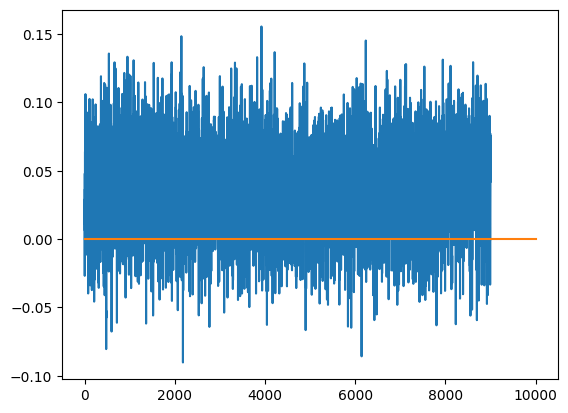

In [381]:
plt.plot(Bs[1000:,0,0])
plt.plot([0, nr_sim], [B_true[0,0], B_true[0,0]])

# Gibbs sampler student t

In [4]:

tol = 1e-6
max_iter = 200
nu = 10
rnd = np.random.RandomState(42)

n = 10000
r = 5
d = 3

X = rnd.normal(loc = 0, scale = 1, size = (n,r))


# Generate coef matrix
B_true = rnd.normal(loc = 0, scale = 1, size = (d,r))
B_true[np.abs(B_true)<0.7] = 0

psi_true = 1*np.identity(d)
# Generate observations
st_dist = student_t(df = nu, scale = 1)
st_dist.random_state = np.random.RandomState(5)
mt_dist = multivariate_t(df = nu, shape = psi_true*(nu-1)/nu)


gamma_true = rnd.normal(loc = 0, scale = 1, size = (n))
tau_true = rnd.gamma(shape = nu/2, scale = 2/nu, size = (n))
z = rnd.multivariate_normal(mean = np.zeros(d), cov = psi_true, size = (n))
epsilon =  mt_dist.rvs(size = (n))#st_distz*(1/np.sqrt(tau_true[:, np.newaxis]))


Y_cov = gamma_true[:, np.newaxis]*np.dot(X, B_true.T) + epsilon




In [5]:
from scipy.stats import invwishart,matrix_normal
B_init_em = np.ones((d,r))#B_true.copy()#
psi_init = np.identity(d)
psi_inv_init = np.linalg.inv(psi_init)
tau =  np.ones(n)# tau_true.copy()#np.random.uniform(size = n)
gamma =   np.ones(n)#gamma_true.copy()#np.ones(n)#np.random.normal(size = n) #gamma_true# np.random.normal(size = n)#np.ones(n)

psi_0 = np.identity(d)
V_0 = np.identity(r)
V_0_inv = np.linalg.inv(V_0)
B_0 = 0.1*np.ones((d,r))


nr_sim = 10000
Psis = np.zeros((nr_sim+1, d,d))
Psis[0] = psi_true#psi_init
Bs = np.zeros((nr_sim+1, d,r))
Bs[0] = B_init_em

for i in range(nr_sim):

    psi_inv_i = np.linalg.inv(Psis[i])
    Bs_i = Bs[i]

    # simuate gamma
    v = np.abs(1+(tau[:,np.newaxis]*X*np.dot(X, np.dot(Bs_i.T, psi_inv_i).dot(Bs_i))).sum(1)) ** (-1)
    errors =Y_cov.copy()
    m =  v*(errors*np.dot(tau[:,np.newaxis]*X, Bs_i.T).dot(psi_inv_i)).sum(1)
    gamma = np.random.normal(loc = m, scale = v**0.5, size = n)

    # simulate tau
    alpha_1 = float((nu+d)/2.0)
    tmp = Y_cov - gamma[:, np.newaxis]*np.dot(X, Bs_i.T)
    beta = (nu + (tmp * np.dot(tmp, psi_inv_i)).sum(1))/2.0
    tau = np.random.gamma(shape = alpha_1, scale = 1/beta, size = n)


    # simulate psi
    X_gamma = gamma[:,np.newaxis]*X*np.sqrt(tau[:, np.newaxis])
    Y_gamma = np.sqrt(tau[:, np.newaxis])*Y_cov
    colcov = np.linalg.inv(np.dot(X_gamma.T, X_gamma) + V_0_inv )
    B_n = np.dot(np.dot(Y_gamma.T, X_gamma) + np.dot(B_0, V_0_inv), colcov )
    #psi_n = psi_0+ np.dot((Y_cov-np.dot(X_gamma, B_n.T)).T,Y_cov-np.dot(X_gamma, B_n.T)) + np.dot((B_n-B_0), V_0_inv).dot((B_n-B_0).T)
    Psis[i+1] = Psis[i]

    # simulate B
    Bs[i+1] = matrix_normal.rvs(mean = B_n, rowcov=Psis[i+1], colcov= colcov)

    




In [6]:
np.round(np.mean(Bs[1000:], 0),2)

array([[ 0.  ,  0.02,  0.96,  1.51, -0.  ],
       [ 1.  ,  0.03, -0.01,  1.48, -0.01],
       [ 0.01,  0.03,  1.04,  1.12, -0.84]])

In [7]:
B_true

array([[ 0.        ,  0.        ,  0.95179076,  1.53283114,  0.        ],
       [ 1.01154375,  0.        ,  0.        ,  1.48573207,  0.        ],
       [ 0.        ,  0.        ,  1.03715129,  1.12622701, -0.84213114]])

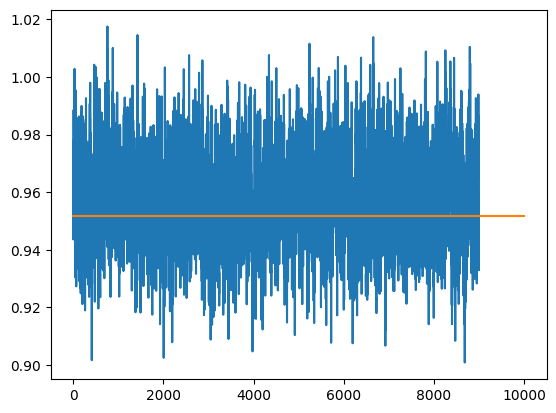

In [8]:
plt.plot(Bs[1000:,0,2])
plt.plot([0, nr_sim], [B_true[0,2], B_true[0,2]])

# EM Gibbs student t

In [9]:

tol = 1e-6
max_iter = 200
nu = 5
rnd = np.random.RandomState(42)

n = 100
r = 5
d = 3

X = rnd.normal(loc = 0, scale = 1, size = (n,r))


# Generate coef matrix
B_true = rnd.normal(loc = 0, scale = 1, size = (d,r))
B_true[np.abs(B_true)<0.7] = 0

psi_true = 1.0*np.identity(d)
# Generate observations
st_dist = student_t(df = nu, scale = 1)
st_dist.random_state = np.random.RandomState(5)
mt_dist = multivariate_t(df = nu, shape = psi_true*(nu-1)/nu)


gamma_true = rnd.normal(loc = 0, scale = 1, size = (n))
tau_true = rnd.gamma(shape = nu/2, scale = 2/nu, size = (n))
z = rnd.multivariate_normal(mean = np.zeros(d), cov = psi_true, size = (n))
epsilon =  mt_dist.rvs(size = (n))#st_distz*(1/np.sqrt(tau_true[:, np.newaxis]))


Y_cov = gamma_true[:, np.newaxis]*np.dot(X, B_true.T) + epsilon






In [10]:

psi_0 = np.identity(d)
V_0 = np.identity(r)
V_0_inv = np.linalg.inv(V_0)
B_0 = 0.1*np.ones((d,r))


nr_sim = 1000
nr_em = 100
Psis = np.zeros((nr_em+1, d,d))
Psis[0] = psi_true#psi_init
Bs = np.zeros((nr_em+1, d,r))
Bs[0] = B_0



for b in range(nr_em):

    gammas = np.ones((nr_sim, n))
    taus = np.ones((nr_sim, n))

    for i in range(nr_sim):

        psi_inv_i = np.linalg.inv(Psis[b])
        Bs_i = Bs[b]


        # simuate gamma
        v = np.abs(1+(taus[i,:,np.newaxis]*X*np.dot(X, np.dot(Bs_i.T, psi_inv_i).dot(Bs_i))).sum(1)) ** (-1)
        errors =Y_cov.copy()
        m =  v*(errors*np.dot(taus[i,:,np.newaxis]*X, Bs_i.T).dot(psi_inv_i)).sum(1)
        gammas[i] = np.random.normal(loc = m, scale = v**0.5, size = n)

        # simulate tau
        alpha_1 = float((nu+d)/2.0)
        tmp = Y_cov - gammas[i,:, np.newaxis]*np.dot(X, Bs_i.T)
        beta = (nu + (tmp * np.dot(tmp, psi_inv_i)).sum(1))/2.0
        taus[i] = np.random.gamma(shape = alpha_1, scale = 1/beta, size = n)

    
    tg = np.mean(taus[100:]*gammas[100:],0)
    tgsq = np.mean(taus[100:]*gammas[100:]**2,0)


    X_tg = X*tg[:,np.newaxis]
    X_tgsq = X*tgsq[:,np.newaxis]

    Bs[b+1] = np.dot(Y_cov.T, X_tg).dot(np.linalg.inv(np.dot(X_tgsq.T, X)))
    Psis[b+1] = Psis[b]




In [19]:
np.sum((Bs[-1]-B_true)**2)

0.2028557276136531

In [13]:
B_init_em = np.ones((d,r))#B_true.copy()#
psi_init = np.identity(d)
psi_inv_init = np.linalg.inv(psi_init)
tau_mean =  np.ones(n)# tau_true.copy()#np.random.uniform(size = n)
gamma_mean =   np.ones(n)#gamma_true.copy()#np.ones(n)#np.random.normal(size = n) #gamma_true# np.random.normal(size = n)#np.ones(n)


max_iter = 100

for i in range(max_iter):


    # E-step 2
    v = np.abs(1+(tau_mean[:,np.newaxis]*X*np.dot(X, np.dot(B_init_em.T, psi_inv_init).dot(B_init_em))).sum(1)) ** (-1)
    errors = Y_cov.copy()
    m =  v*(errors*np.dot(tau_mean[:,np.newaxis]*X, B_init_em.T).dot(psi_inv_init)).sum(1)
    gamma_mean = m.copy()
    
    # M-step 
    s = v[:,np.newaxis] ** 0.5
    X_tilde =  np.vstack((m[:,np.newaxis]*X,s*X))
    Y_tilde = np.vstack((Y_cov, np.zeros((n,d))))

    B_init_em = np.dot(Y_tilde.T, X_tilde).dot(np.linalg.inv(np.dot(X_tilde.T,X_tilde)))
    #psi_init = np.dot((Y_tilde-np.dot(X_tilde,B_init_em.T)).T, (Y_tilde-np.dot(X_tilde,B_init_em.T)))/n
    #psi_inv_init = np.linalg.inv(psi_init)



In [18]:
B_init_em

array([[ 3.62770929,  1.76923831,  1.66768668,  0.90667198,  3.43019642],
       [ 1.0608137 ,  0.3864039 ,  0.44278037,  0.12784211,  0.99288324],
       [ 0.12298241,  0.39703782,  0.49838807,  0.62828727, -0.19641201]])

In [17]:
np.sum((B_init_em-B_true)**2)

38.45170676285712

# Older

In [ ]:
import numpy as np
from scipy.stats import t as student_t, multivariate_t, multivariate_normal
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [117]:
def plot_things(tau_1, tau_2, m_1, m_2, v_1, v_2, tau_mean_1, tau_mean_2):
    fig, ax = plt.subplots(2,2, figsize = (10,7))
    sns.kdeplot(tau_1, ax = ax[0,0], label = "correct model")
    sns.kdeplot(tau_2, ax = ax[0,0], label = "wrong model")
    ax[0,0].set_title("tau mode")
    ax[0,0].legend()

    sns.kdeplot(m_1, ax = ax[0,1], label = "correct model")
    sns.kdeplot(m_2, ax = ax[0,1], label = "wrong model")
    ax[0,1].set_title("m")
    ax[0,1].legend()


    sns.kdeplot(v_1, ax = ax[1,0], label = "correct model")
    sns.kdeplot(v_2, ax = ax[1,0], label = "wrong model")
    ax[1,0].set_title("v")
    ax[1,0].legend()


    sns.kdeplot(tau_mean_1, ax = ax[1,1], label = "correct model")
    sns.kdeplot(tau_mean_2, ax = ax[1,1], label = "wrong model")
    ax[1,1].set_title("tau mean")
    ax[1,1].legend()



    fig, ax = plt.subplots(2,2, figsize = (10,7))
    ax[0,0].plot(tau_1, label = "correct model")
    ax[0,0].plot(tau_2, label = "wrong model")
    ax[0,0].set_title("tau mode")
    ax[0,0].legend()

    ax[0,1].plot(m_1, label = "correct model")
    ax[0,1].plot(m_2, label = "wrong model")
    ax[0,1].set_title("m")
    ax[0,1].legend()

    ax[1,0].plot(v_1, label = "correct model")
    ax[1,0].plot(v_2, label = "wrong model")
    ax[1,0].set_title("v")
    ax[1,0].legend()

    ax[1,1].plot(tau_mean_1, label = "correct model")
    ax[1,1].plot(tau_mean_2, label = "wrong model")
    ax[1,1].set_title("tau mean")
    ax[1,1].legend()


In [118]:

B_init = B_true# np.ones((d,r))
psi_init = np.identity(d)*(nu-1)/nu
psi_inv_init = np.linalg.inv(psi_init)
tau_init = np.ones(n)
gamma_init = np.ones(n)


#Y, X1, X2, A, B, Psi_inv, tau, gamma, nu, sample

C_1, Psi_1, Psi_inv_1, tau_mean_1, tau_1, m_1,v_1,gamma_1 = one_step(Y_cov, None, X, None, B_init, psi_inv_init, tau_init, gamma_init, nu, 'mode')
C_2, Psi_2, Psi_inv_2, tau_mean_2, tau_2, m_2,v_2,gamma_2 = one_step_wrong(Y_cov, None, X, None, B_init, psi_inv_init, tau_init, gamma_init, nu, 'mode')



print(np.round(C_1,2))
print(np.round(C_2,2))


[[-0.04  0.    1.07  1.67  0.06]
 [ 1.2  -0.   -0.06  1.59  0.02]
 [-0.02  0.01  1.14  1.17 -0.98]]
[[-0.01 -0.    1.01  1.6   0.03]
 [ 1.09  0.01 -0.03  1.51  0.  ]
 [-0.01  0.01  1.07  1.14 -0.89]]


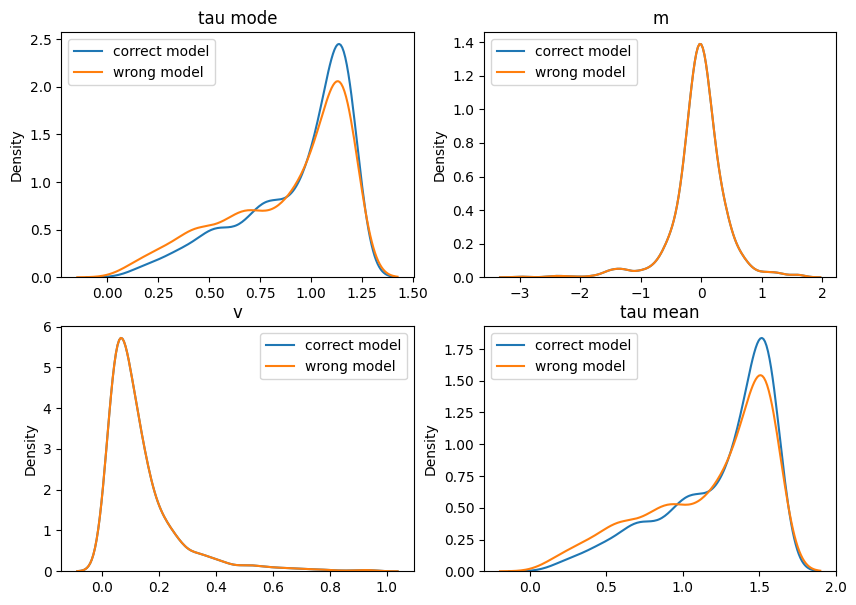

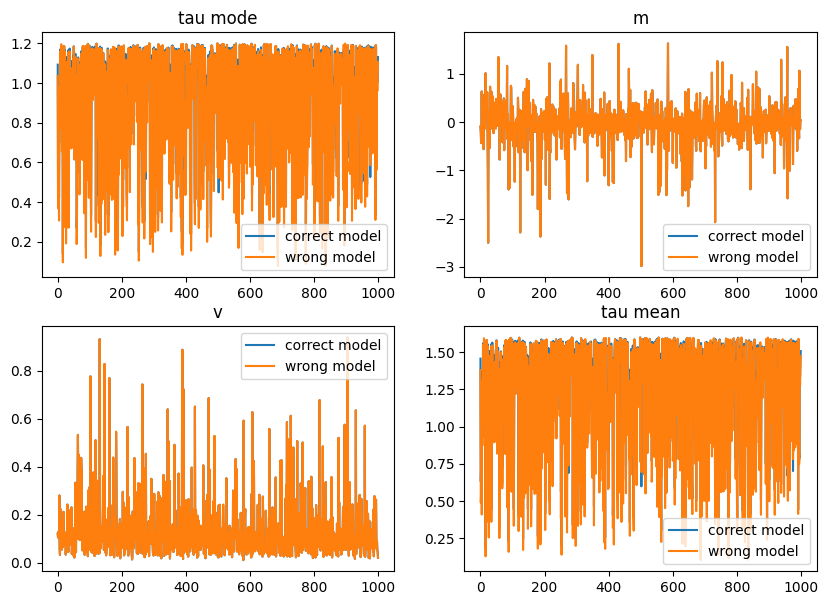

In [211]:
plot_things(tau_1, tau_2, m_1, m_2, v_1, v_2, tau_mean_1, tau_mean_2)

In [212]:
nr_itr = 10


B_init = B_true# np.ones((d,r))
psi_init = np.identity(d)*(nu-1)/nu
psi_inv_init = np.linalg.inv(psi_init)
tau_init = np.ones(n)*1
gamma_init = np.ones(n)*10

C_1 = np.zeros((nr_itr+1, d,r))
C_1[0] = B_init.copy()
psi_1 = np.zeros((nr_itr+1, d,d))
psi_1[0] = psi_init.copy()
psi_inv_1 = np.zeros((nr_itr+1, d,d))
psi_inv_1[0] = psi_inv_init.copy()
tau_1 = np.zeros((nr_itr+1, n))
tau_1[0] = tau_init.copy()
gamma_1 = np.zeros((nr_itr+1, n))
gamma_1[0] = gamma_init.copy()
tau_mean_1 = np.zeros((nr_itr+1, n))
tau_mean_1[0] = tau_init.copy()
m_1 = np.zeros((nr_itr+1, n))
v_1 = np.zeros((nr_itr+1, n))


C_2 = np.zeros((nr_itr+1, d,r))
C_2[0] = B_init.copy()
psi_2 = np.zeros((nr_itr+1,d,d))
psi_2[0] = psi_init.copy()
psi_inv_2 = np.zeros((nr_itr+1, d,d))
psi_inv_2[0] = psi_inv_init.copy()
tau_2 = np.zeros((nr_itr+1, n))
tau_2[0] = tau_init.copy()
gamma_2 = np.zeros((nr_itr+1, n))
gamma_2[0] = gamma_init.copy()
tau_mean_2 = np.zeros((nr_itr+1, n))
tau_mean_2[0] = tau_init.copy()
m_2 = np.zeros((nr_itr+1, n))
v_2 = np.zeros((nr_itr+1, n))

#Y, X1, X2, A, B, Psi_inv, tau, gamma, nu, sample

for i in range(nr_itr):
    C_1[i+1], psi_1[i+1], psi_inv_1[i+1], tau_mean_1[i+1], tau_1[i+1], m_1[i+1],v_1[i+1], gamma_1[i+1] = one_step(Y_cov, None, X, None, C_1[i], psi_inv_1[i], tau_1[i], gamma_1[i], nu, 'mean')
    C_2[i+1], psi_2[i+1], psi_inv_2[i+1], tau_mean_2[i+1], tau_2[i+1], m_2[i+1],v_2[i+1], gamma_2[i+1] = one_step_wrong(Y_cov, None, X, None, C_2[i], psi_inv_2[i], tau_2[i], gamma_2[i], nu, 'mean')



In [122]:
print(tau_1[-1][:5])
print(tau_mean_1[-1][:5])

[1.52526164 1.39596514 0.92609881 0.69103345 1.51315807]
[1.52526164 1.39596514 0.92609881 0.69103345 1.51315807]


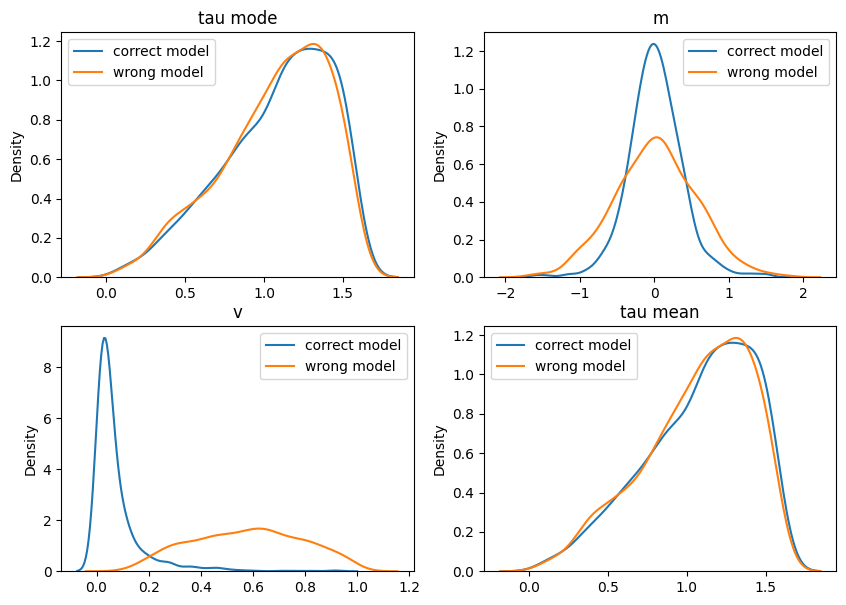

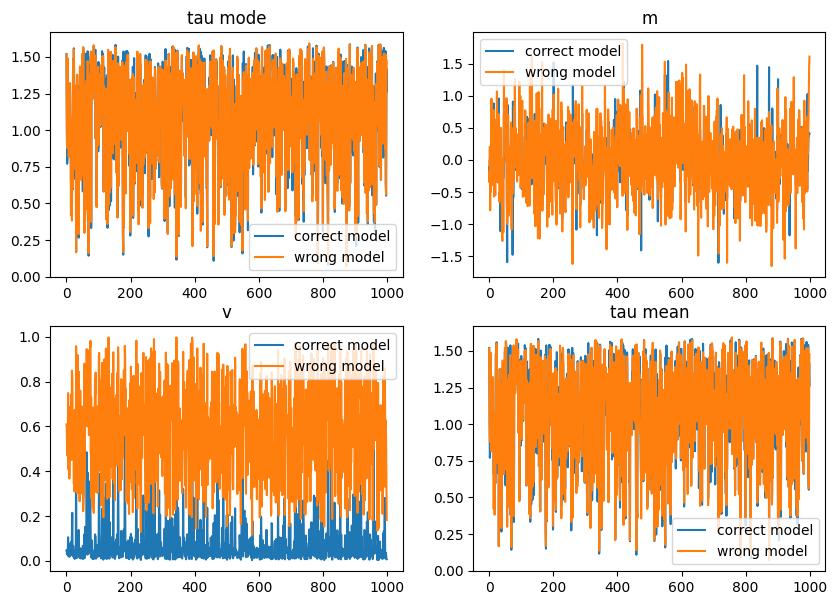

In [123]:
idx = 5
plot_things(tau_1[idx], tau_2[idx], m_1[idx], m_2[idx], v_1[idx], v_2[idx], tau_mean_1[idx], tau_mean_2[idx])

In [30]:
print(np.round(B_true,2))
print("")
print(np.round(C_1[-1],2))
print("")
print(np.round(C_2[-1],2))
print("Error correct:")
print(np.linalg.norm(B_true-C_1))
print("Error wrong:")
print(np.linalg.norm(B_true-C_2))

[[ 0.    0.   -1.8   0.    0.73]
 [-1.27  1.05  0.   -0.73  0.  ]
 [ 1.6   0.73  0.    0.    0.  ]]

[[ 2.24 -0.74  0.98  0.96 -0.92]
 [ 3.32 -1.22  1.26  1.5  -1.23]
 [-1.24  0.23 -0.36 -0.42  0.39]]

[[ 0.01 -0.03 -1.75  0.07  0.86]
 [-1.29  1.03  0.02 -0.79 -0.03]
 [ 1.61  0.72 -0.05  0.08  0.03]]
Error correct:
371.08838613912104
Error wrong:
1.9368954362103128


In [14]:
nr_itr = 1


B_init = B_true# np.ones((d,r))
psi_init = np.identity(d)#*(nu-1)/nu
psi_inv_init = np.linalg.inv(psi_init)
tau_init = np.ones(n)*1
gamma_init = np.ones(n)*10


C_2 = np.zeros((nr_itr+1, d,r))
C_2[0] = B_init.copy()
psi_2 = np.zeros((nr_itr+1,d,d))
psi_2[0] = psi_init.copy()
psi_inv_2 = np.zeros((nr_itr+1, d,d))
psi_inv_2[0] = psi_inv_init.copy()
tau_2 = np.zeros((nr_itr+1, n))
tau_2[0] = tau_init.copy()
gamma_2 = np.zeros((nr_itr+1, n))
gamma_2[0] = gamma_init.copy()
tau_mean_2 = np.zeros((nr_itr+1, n))
m_2 = np.zeros((nr_itr+1, n))
v_2 = np.zeros((nr_itr+1, n))

#Y, X1, X2, A, B, Psi_inv, tau, gamma, nu, sample

for i in range(nr_itr):
    psi_inv_2[i+1] = np.identity(d)
    
    n = Y_cov.shape[0]


    # # Estimate m and v

    # v_2[i+1] = np.abs(1+(tau_2[i][:,np.newaxis]*X*np.dot(X, np.dot(C_2[i].T, psi_inv_2[i]).dot(C_2[i]))).sum(1)) ** (-1)
    # errors = Y_cov.copy()
    # m_2[i+1] =  v_2[i+1]*(errors*np.dot(tau_2[i][:,np.newaxis]*X, C_2[i].T).dot(psi_inv_2[i])).sum(1)
    # gamma_2[i+1] = m_2[i+1].copy()



    # X_tilde = get_X_tilde(None, X, m_2[i+1],v_2[i+1], tau_2[i])
    # Y_tilde = get_Y_tilde(Y_cov, tau_2[i])

    # C_2[i+1], Psi_est, psi_inv_2[i+1] = solve_B_psi(X_tilde, Y_tilde, n)

    tau_mean_2[i+1], tau_2[i+1] = get_tau(Y_cov, None, X, gamma_true, C_2[i], psi_inv_2[i], nu, 'mean')
    X_bar =  get_X_bar(None, X, tau_true, gamma_true)
    Y_bar =  get_Y_bar(Y_cov, tau_true)

    C_2[i+1], Psi_est, _ = solve_B_psi(X_bar, Y_bar, n)
    



In [16]:
print(np.round(B_true,2))

print("")
print(np.round(C_2[-1],2))
print("Error correct:")
print(np.linalg.norm(B_true-C_2[-1]))

[[ 0.    0.   -1.8   0.    0.73]
 [-1.27  1.05  0.   -0.73  0.  ]
 [ 1.6   0.73  0.    0.    0.  ]]

[[-0.22  0.31 -1.89 -0.28  1.19]
 [-0.34  1.28  0.08 -1.14 -0.14]
 [ 1.89  0.58  0.17 -0.78  0.49]]
Error correct:
1.5956066620723637


In [6]:
def obj(param, d, r, Y, X, gamma, Psi, tau):

    B = np.reshape(param, newshape = (d,r))
    n = Y.shape[0]

    return np.sum([np.inner(Y[i] - gamma[i]* np.dot(B, X[i]), Y[i] - gamma[i]*np.dot(B, X[i]))*tau[i] for i in range(n)])




In [10]:
from scipy.optimize import minimize
x0 = np.ones(d*r)
res = minimize(obj, x0, method='BFGS', tol=1e-6, args=(d,r,Y_cov, X, gamma_true, np.identity(d), tau_true))

In [12]:
np.round(np.reshape(res.x, newshape = (d,r)),2)

array([[ 0.49, -0.85, -3.46, -0.28, -0.12],
       [-1.53,  1.37, -0.28, -2.39,  0.86],
       [ 1.22,  0.87,  0.22,  0.22,  0.4 ]])

In [201]:
nr_itr = 5


B_init = B_true# np.ones((d,r))
psi_init = np.identity(d)*(nu-1)/nu
psi_inv_init = np.linalg.inv(psi_init)
tau_init = np.ones(n)*1
gamma_init = np.ones(n)*10

C_1 = np.zeros((nr_itr+1, d,r))
C_1[0] = B_init.copy()
psi_1 = np.zeros((nr_itr+1, d,d))
psi_1[0] = psi_init.copy()
psi_inv_1 = np.zeros((nr_itr+1, d,d))
psi_inv_1[0] = psi_inv_init.copy()
tau_1 = np.zeros((nr_itr+1, n))
tau_1[0] = tau_init.copy()
gamma_1 = np.zeros((nr_itr+1, n))
gamma_1[0] = gamma_init.copy()
tau_mean_1 = np.zeros((nr_itr+1, n))
m_1 = np.zeros((nr_itr+1, n))
v_1 = np.zeros((nr_itr+1, n))


C_2 = np.zeros((nr_itr+1, d,r))
C_2[0] = B_init.copy()
psi_2 = np.zeros((nr_itr+1,d,d))
psi_2[0] = psi_init.copy()
psi_inv_2 = np.zeros((nr_itr+1, d,d))
psi_inv_2[0] = psi_inv_init.copy()
tau_2 = np.zeros((nr_itr+1, n))
tau_2[0] = tau_init.copy()
gamma_2 = np.zeros((nr_itr+1, n))
gamma_2[0] = gamma_init.copy()
tau_mean_2 = np.zeros((nr_itr+1, n))
m_2 = np.zeros((nr_itr+1, n))
v_2 = np.zeros((nr_itr+1, n))

#Y, X1, X2, A, B, Psi_inv, tau, gamma, nu, sample

for i in range(nr_itr):
    psi_inv_2[i] = np.identity(d)
    
    n = Y_cov.shape[0]


    # # Estimate m and v

    # v_2[i+1] = np.abs(1+(tau_2[i][:,np.newaxis]*X*np.dot(X, np.dot(C_2[i].T, psi_inv_2[i]).dot(C_2[i]))).sum(1)) ** (-1)
    # errors = Y_cov.copy()
    # m_2[i+1] =  v_2[i+1]*(errors*np.dot(tau_2[i][:,np.newaxis]*X, C_2[i].T).dot(psi_inv_2[i])).sum(1)
    # gamma_2[i+1] = m_2[i+1].copy()



    # X_tilde = get_X_tilde(None, X, m_2[i+1],v_2[i+1], tau_2[i])
    # Y_tilde = get_Y_tilde(Y_cov, tau_2[i])

    # C_2[i+1], Psi_est, psi_inv_2[i+1] = solve_B_psi(X_tilde, Y_tilde, n)

    tau_mean_2[i+1], tau_2[i+1] = get_tau(Y_cov, None, X, gamma_true, C_2[i], psi_inv_2[i], nu, 'mean')
    res = minimize(obj, x0, method='Nelder-Mead', tol=1e-3, args=(d,r,Y_cov, X, gamma_true, np.identity(d), tau_mean_2[i+1]))

    C_2[i+1]= np.reshape(res.x, newshape = (d,r))
    



In [202]:
print(np.round(B_true,2))

print("")
print(np.round(C_2[-1],2))
print("Error correct:")
print(np.linalg.norm(B_true-C_2[-1]))

[[ 0.    0.   -1.8   0.    0.73]
 [-1.27  1.05  0.   -0.73  0.  ]
 [ 1.6   0.73  0.    0.    0.  ]]

[[ 0.11  0.12 -1.59  0.47  0.83]
 [-1.56  0.48 -0.13 -0.92 -0.37]
 [ 1.63  0.04 -0.41  0.71 -0.23]]
Error correct:
1.4467394176613853


In [103]:
i = 10
np.dot(C_2[i].T, psi_inv_2[i]).dot(C_2[i])

array([[ 0.99597864,  0.00160083, -0.12536332,  0.61715752,  0.0547349 ],
       [ 0.00160083,  0.07475257, -0.23670795, -0.0177744 ,  0.05917171],
       [-0.12536332, -0.23670795,  1.19307314, -0.16347034, -0.56411334],
       [ 0.61715752, -0.0177744 , -0.16347034,  0.43625422,  0.1443817 ],
       [ 0.0547349 ,  0.05917171, -0.56411334,  0.1443817 ,  0.36931828]])

<AxesSubplot: ylabel='Density'>

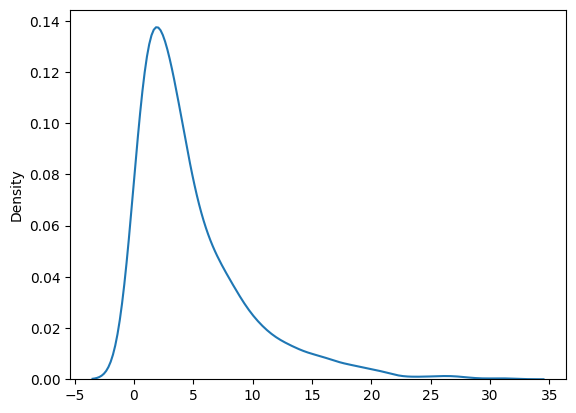

In [105]:
i = 10
sns.kdeplot((tau_2[i][:,np.newaxis]*X*np.dot(X, np.dot(C_2[i].T, psi_inv_2[i]).dot(C_2[i]))).sum(1))

C:\Users\User\AppData\Local\Temp\ipykernel_26920\1985626996.py:1: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(v_2[10])


<AxesSubplot: ylabel='Density'>

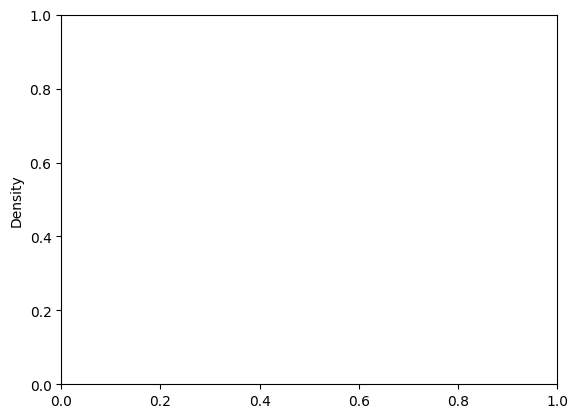

In [106]:
sns.kdeplot(v_2[10])

sns.kde